In [1]:
import pandas as pd
import plotly.express as px
from helper import get_conn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Connect to the PostgreSQL database
conn, cursor = get_conn()
# Query data from the view
query = """
SELECT
    order_id,
    ARRAY_AGG(category_name) AS category_names
FROM
    datawarehouse.orders_fact
GROUP BY
    order_id;

"""
cursor.execute(query)

# Fetch the data into a Pandas DataFrame
columns = [desc[0] for desc in cursor.description]
data = cursor.fetchall()
df = pd.DataFrame(data, columns=columns)

# Close the database connection
cursor.close()
conn.close()


Connected to the database


In [3]:
df.head()

,order_id,category_names
0,1,"[Cruisers Bicycles, Mountain Bikes, Cruisers B..."
1,2,"[Cruisers Bicycles, Cruisers Bicycles]"
2,3,"[Cruisers Bicycles, Mountain Bikes]"
3,4,[Mountain Bikes]
4,5,"[Cruisers Bicycles, Comfort Bicycles, Cyclocro..."


In [4]:
df.describe()

,order_id
count,1615.000000
mean,808.000000
std,466.354658
min,1.000000
25%,404.500000
50%,808.000000
75%,1211.500000
max,1615.000000


In [5]:
df

,order_id,category_names
0,1,"[Cruisers Bicycles, Mountain Bikes, Cruisers B..."
1,2,"[Cruisers Bicycles, Cruisers Bicycles]"
2,3,"[Cruisers Bicycles, Mountain Bikes]"
3,4,[Mountain Bikes]
4,5,"[Cruisers Bicycles, Comfort Bicycles, Cyclocro..."
...,...,...
1610,1611,"[Cruisers Bicycles, Electric Bikes, Road Bikes]"
1611,1612,"[Cruisers Bicycles, Electric Bikes, Children B..."
1612,1613,"[Road Bikes, Children Bicycles]"
1613,1614,"[Mountain Bikes, Cruisers Bicycles, Road Bikes]"


In [6]:
import pandas as pd


df['category_names'] = df['category_names'].apply(tuple)

# Identify unique groups of 'category_names'
unique_groups = df['category_names'].unique()

# Create a new DataFrame with unique groups
df = pd.DataFrame({'category_names': unique_groups})

# Display the unique groups DataFrame
print(df)


                                        category_names
0    (Cruisers Bicycles, Mountain Bikes, Cruisers B...
1               (Cruisers Bicycles, Cruisers Bicycles)
2                  (Cruisers Bicycles, Mountain Bikes)
3                                    (Mountain Bikes,)
4    (Cruisers Bicycles, Comfort Bicycles, Cyclocro...
..                                                 ...
676  (Road Bikes, Electric Bikes, Children Bicycles...
677  (Comfort Bicycles, Mountain Bikes, Children Bi...
678  (Road Bikes, Cyclocross Bicycles, Cruisers Bic...
679  (Cruisers Bicycles, Electric Bikes, Children B...
680    (Cruisers Bicycles, Road Bikes, Electric Bikes)

[681 rows x 1 columns]


In [7]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert the 'category_names' column to a list of lists
transactions = df['category_names'].tolist()

# Use TransactionEncoder to one-hot encode the data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# Convert the encoded array to a DataFrame
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.55 )

# Display the resulting rules
rules = rules.drop(4, axis=0)
rules = rules.reset_index(drop=True)
print(rules)


           antecedents          consequents  antecedent support  \
0  (Children Bicycles)  (Cruisers Bicycles)            0.502203   
1  (Children Bicycles)     (Mountain Bikes)            0.502203   
2   (Comfort Bicycles)  (Cruisers Bicycles)            0.417034   
3   (Comfort Bicycles)     (Mountain Bikes)            0.417034   
4  (Cruisers Bicycles)     (Mountain Bikes)            0.653451   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.653451  0.305433    0.608187  0.930731 -0.022732    0.884476   
1            0.613803  0.279001    0.555556  0.905104 -0.029252    0.868943   
2            0.653451  0.248164    0.595070  0.910658 -0.024347    0.855826   
3            0.613803  0.236417    0.566901  0.923588 -0.019560    0.891706   
4            0.613803  0.389134    0.595506  0.970190 -0.011957    0.954764   

   zhangs_metric  
0      -0.130061  
1      -0.173977  
2      -0.144047  
3      -0.124281  
4      -0.081442  


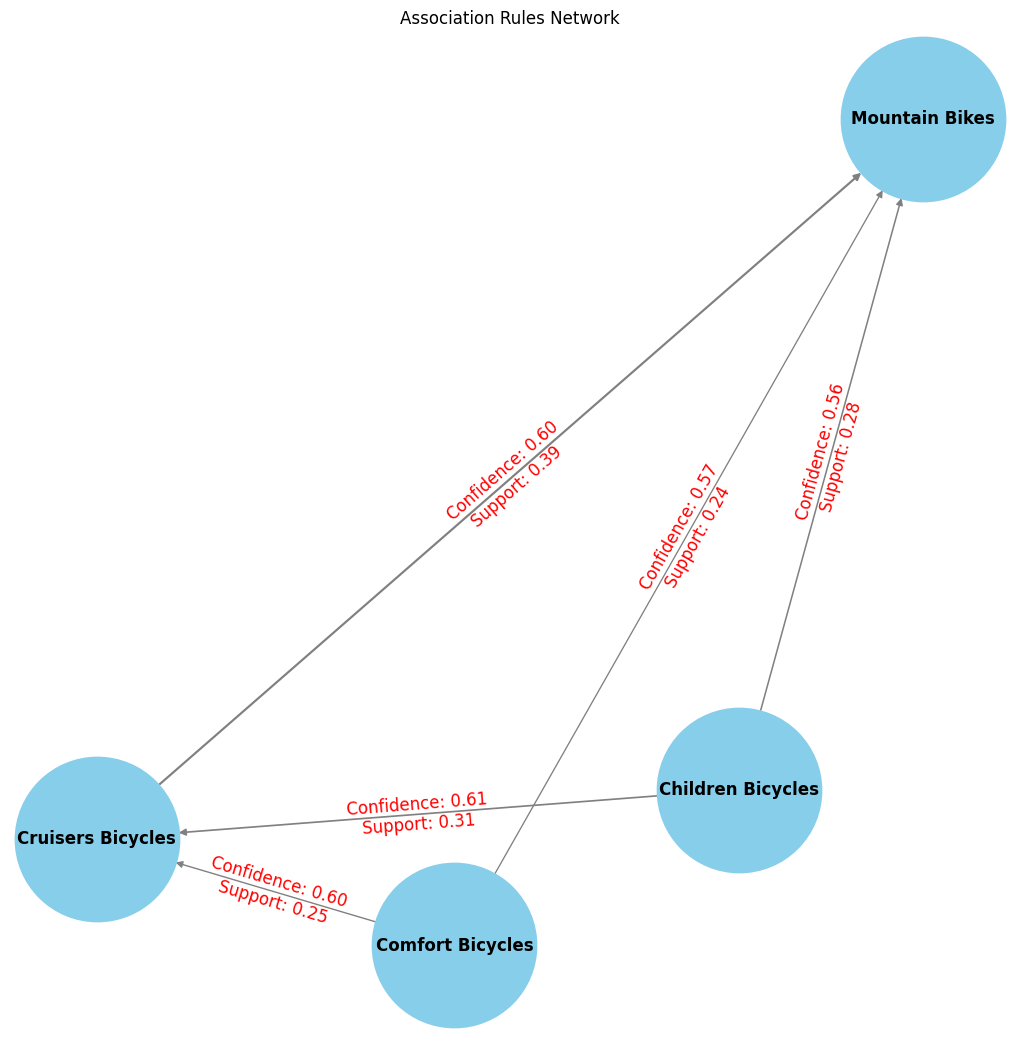

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'])

# Draw the graph
pos = nx.spring_layout(G)  # Fixed seed for reproducibility
edge_labels = {(row['antecedents_str'], row['consequents_str']): f"Confidence: {row['confidence']:.2f}\nSupport: {row['support']:.2f}" for _, row in rules.iterrows()}

# Set node and edge colors
node_color = 'skyblue'
edge_color = 'gray'

# Set a single scalar for node size
node_size = 14000

# Set edge width based on support
edge_width = [4 * G.edges[e]['support'] for e in G.edges]

# Increase figure size
plt.figure(figsize=(10, 10))

# Draw the graph with improved styling
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=node_size, node_color=node_color, font_size=12, edge_color=edge_color, width=edge_width)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="none"))

plt.title("Association Rules Network")
plt.show()


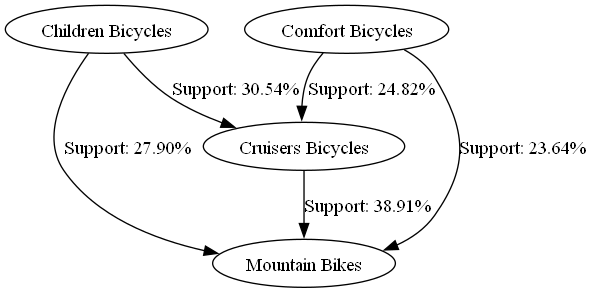

In [9]:
import networkx as nx
from graphviz import Digraph

# Create a directed graph
G = nx.DiGraph()

# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'])

# Create a Graphviz Digraph
dot = Digraph(comment='Association Rules Network')

# Add nodes and edges to Graphviz Digraph
for node in G.nodes():
    dot.node(node, label=node)

for edge in G.edges(data=True):
    dot.edge(edge[0], edge[1], label=f"Support: {edge[2]['support']*100:.2f}%")

# Render and save the graph as an image
dot.render('association_rules_network', format='png', cleanup=True)

# Display the image
from IPython.display import Image
Image(filename='association_rules_network.png')


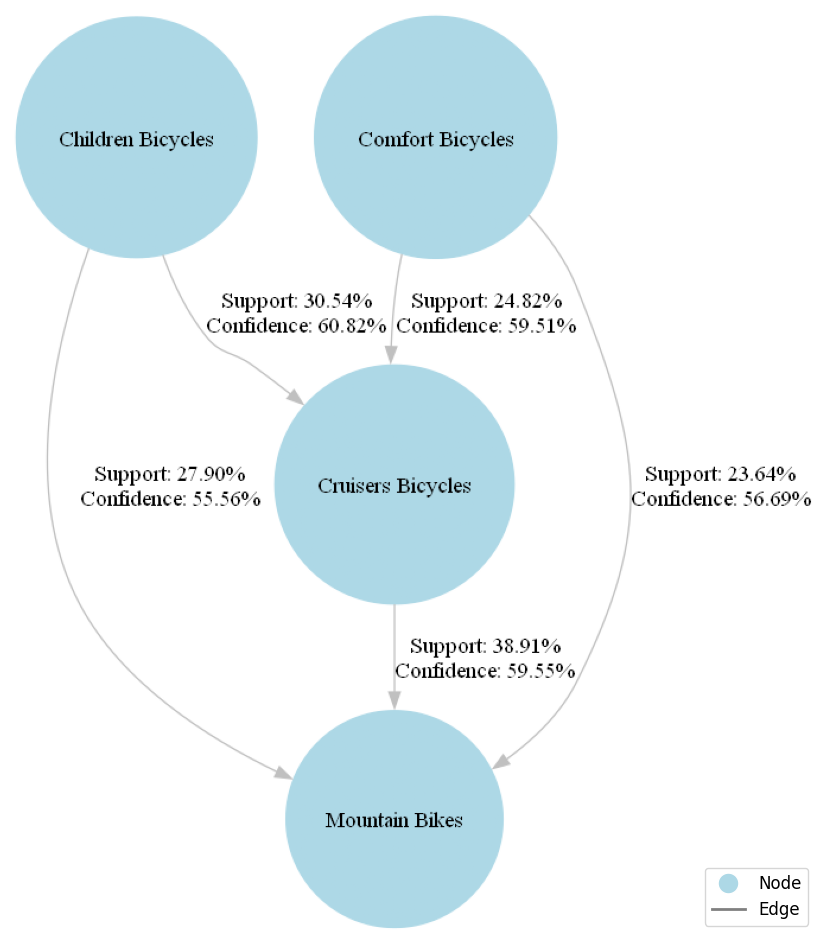

In [10]:
import networkx as nx
from graphviz import Digraph
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'], confidence=row['confidence'])

# Create a Graphviz Digraph
dot = Digraph(comment='Association Rules Network', format='png', graph_attr={'ratio': 'auto'})

# Add nodes and edges to Graphviz Digraph
for node in G.nodes():
    dot.node(node, label=node, style='filled', color='lightblue', fontcolor='black',shape='circle')

for edge in G.edges(data=True):
    label = f"Support: {edge[2]['support']*100:.2f}%\nConfidence: {edge[2]['confidence']*100:.2f}%"
    dot.edge(edge[0], edge[1], label=label, color='gray')

# Render and save the graph as an image
dot.render('association_rules_network', cleanup=True)

# Display the image with adjusted size
plt.figure(figsize=(12, 12))
plt.imshow(plt.imread('association_rules_network.png'))
plt.axis('off')

# Add legend for support and confidence with adjusted size
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=15, label='Node'),
    plt.Line2D([0], [0], color='gray', lw=2, label='Edge')
]

plt.legend(handles=legend_labels, loc='lower right', fontsize='large')


plt.show()


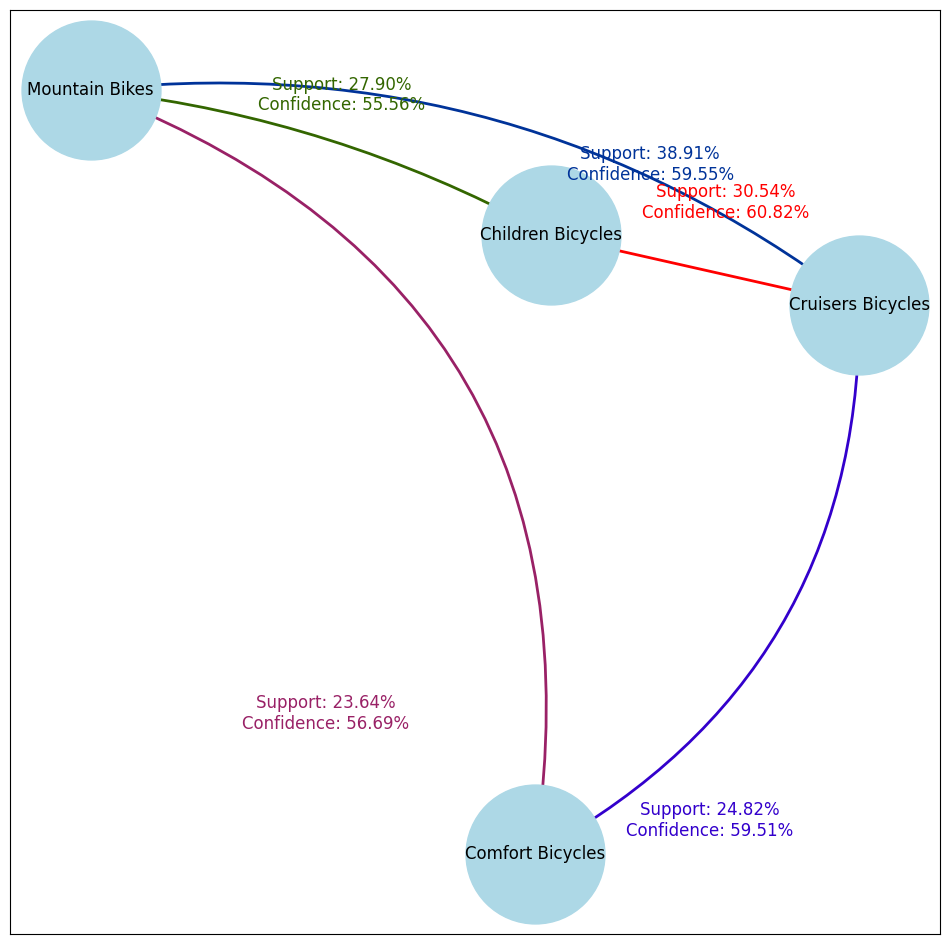

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap



# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
G = nx.DiGraph()
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'], confidence=row['confidence'])

# Create a colormap
cmap = LinearSegmentedColormap.from_list('label_cmap', ['red', 'green', 'blue', 'purple', 'orange'])

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Draw nodes
pos = nx.spring_layout(G)  # Added seed for reproducibility
node_size = 10000  # Adjust node size as needed
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue', ax=ax)

# Draw edges with arrows and different colors
for i, (u, v, data) in enumerate(G.edges(data=True)):
    label = f"Support: {data['support']*100:.2f}%\nConfidence: {data['confidence']*100:.2f}%"
    color = cmap(i / len(G.edges()))
    
    # Add arrows to edges
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=[color], width=2, ax=ax,
                           connectionstyle=f'arc3,rad={0.1*i}', arrowsize=15, arrowstyle='->')

    # Add edge labels
    edge_x, edge_y = np.array(pos[u]) + np.array(pos[v]) / 2
    ax.text(edge_x, edge_y, label, fontsize=12, ha='center', va='center', color=color)

# Add node labels
nx.draw_networkx_labels(G, pos, font_color='black', font_size=12, ax=ax)

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

plt.show()


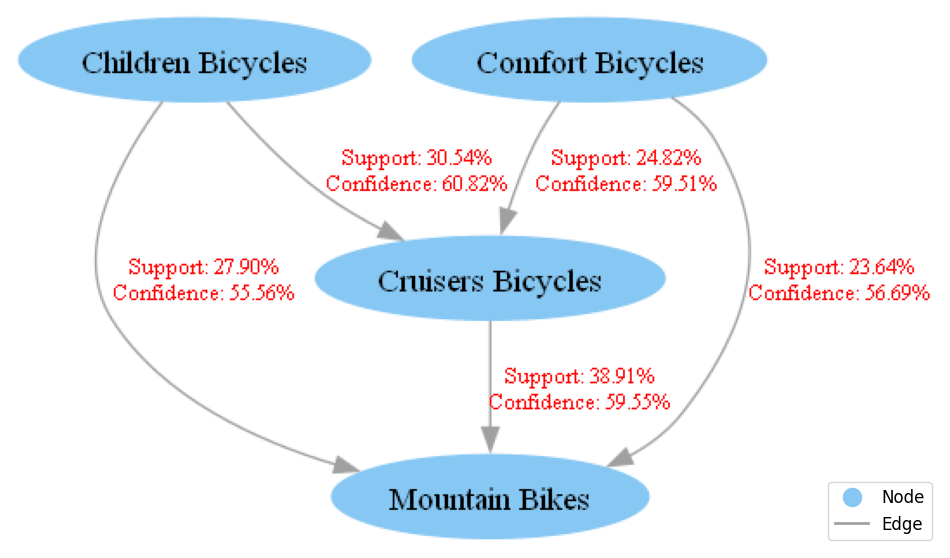

In [12]:
import networkx as nx
from graphviz import Digraph
import matplotlib.pyplot as plt
import seaborn as sns  

# Create a directed graph
G = nx.DiGraph()


# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'], confidence=row['confidence'])

# Create a Graphviz Digraph
dot = Digraph(comment='Association Rules Network', format='png', graph_attr={'ratio': 'auto'})

# Add nodes and edges to Graphviz Digraph
for node in G.nodes():
    dot.node(node, label=node, style='filled', color='#86c7f3', fontcolor='black', width='1.2')  # Adjust the color code as needed

for edge in G.edges(data=True):
    label = f"Support: {edge[2]['support']*100:.2f}%\nConfidence: {edge[2]['confidence']*100:.2f}%"
    dot.edge(edge[0], edge[1], label=label, color='#a0a0a0', fontcolor='#ff0000', fontsize='10')  # Adjust the color code as needed

# Save the graph as an image
dot.render('association_rules_network', cleanup=True)

# Display the image with adjusted size
plt.figure(figsize=(12, 12))
plt.imshow(plt.imread('association_rules_network.png'))
plt.axis('off')

# Add legend for support and confidence with adjusted size
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#86c7f3', markersize=15, label='Node'),
    plt.Line2D([0], [0], color='#a0a0a0', lw=2, label='Edge')
]

plt.legend(handles=legend_labels, loc='lower right', fontsize='large')

plt.show()


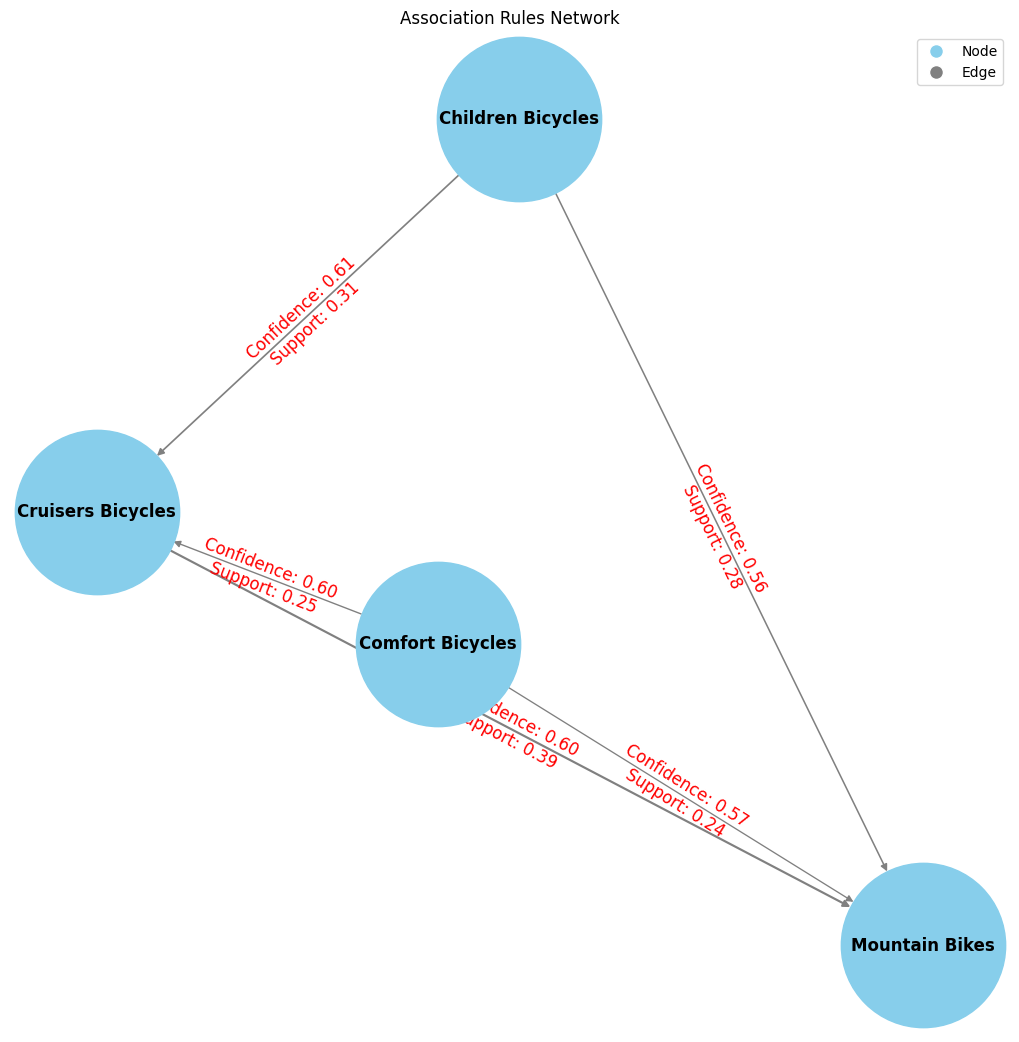

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'])

# Draw the graph
pos = nx.spring_layout(G)  # Fixed seed for reproducibility
edge_labels = {(row['antecedents_str'], row['consequents_str']): f"Confidence: {row['confidence']:.2f}\nSupport: {row['support']:.2f}" for _, row in rules.iterrows()}

# Set node and edge colors
node_color = 'skyblue'
edge_color = 'gray'

# Set a single scalar for node size
node_size = 14000

# Set edge width based on support
edge_width = [4 * G.edges[e]['support'] for e in G.edges]

# Increase figure size
plt.figure(figsize=(10, 10))

# Draw the graph with improved styling
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=node_size, node_color=node_color, font_size=12, edge_color=edge_color, width=edge_width)

# Draw legend
legend_labels = {'Node': 'skyblue', 'Edge': 'gray'}
legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_labels[label], markersize=10) for label in legend_labels]
plt.legend(legend, legend_labels.keys(), loc='best')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="none"))

plt.title("Association Rules Network")
plt.show()


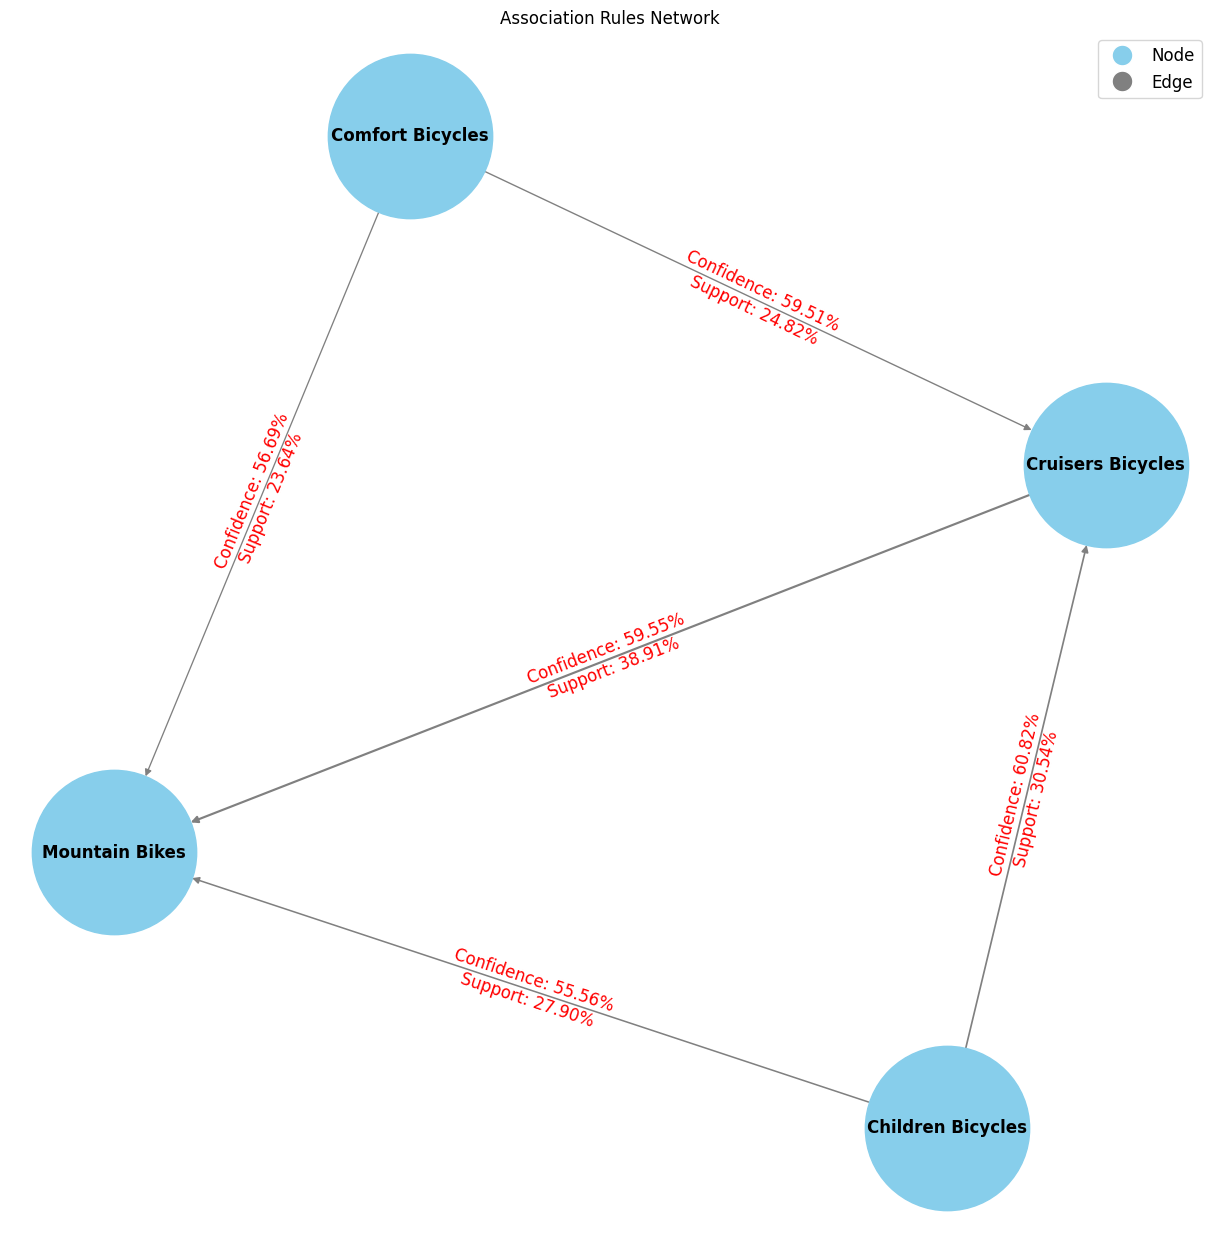

In [16]:
import networkx as nx
import matplotlib.pyplot as plt


# Convert frozenset node labels to strings
rules['antecedents_str'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents_str'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

# Add nodes and edges to the graph
for _, row in rules.iterrows():
    G.add_node(row['antecedents_str'])
    G.add_node(row['consequents_str'])
    G.add_edge(row['antecedents_str'], row['consequents_str'], support=row['support'])

# Draw the graph
pos = nx.spring_layout(G, seed=2)  # Fixed seed for reproducibility
edge_labels = {(row['antecedents_str'], row['consequents_str']):
               f"Confidence: {row['confidence']:.2%}\nSupport: {row['support']:.2%}" for _, row in rules.iterrows()}

# Set node and edge colors
node_color = 'skyblue'
edge_color = 'gray'

# Set a single scalar for node size
node_size = 14000

# Set edge width based on support
edge_width = [4 * G.edges[e]['support'] for e in G.edges]

# Increase figure size
plt.figure(figsize=(12, 12))

# Draw the graph with improved styling
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=node_size, node_color=node_color, font_size=12, edge_color=edge_color, width=edge_width)

# Draw legend with increased size
legend_labels = {'Node': 'skyblue', 'Edge': 'gray'}
legend_size = 15  # Adjust the legend size as needed

legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=legend_labels[label], markersize=legend_size) for label in legend_labels]
plt.legend(legend, legend_labels.keys(), loc='best', fontsize='large')

# Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12,
                             bbox=dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="none"))

plt.title("Association Rules Network")
plt.show()
